# Urbanization level clustering without Porto and Lisbon

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings

import matplotlib.pyplot as plt
import seaborn as sns
from src.config import CLUSTERING_CONFIGS, MASTER_DF_FILE, RANDOM_SEED, YEARS
from src.data.loader import DataLoader
from src.features.dimentionality import UrbanizationPCA
from src.models.clustering import ClusteringEngine


warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
EXP_KEY = "urban_cut"
config = CLUSTERING_CONFIGS[EXP_KEY]

### PCA

In [5]:
pca_engine = UrbanizationPCA(n_components=2)

df_pca = DataLoader(MASTER_DF_FILE).load_dataset(features=config["features"], exclude_values=config["exclude"])

pca_result = pca_engine.run_pca(df_pca)

We categorize regions into distinct **Urbanization Tiers** by clustering on three core dimensions: **Service Availability**, **Income**, and **Population Density**.

To visualize the structure of this high-dimensional feature space, we project the data onto its first two Principal Components:
* **PC1 (Infrastructure):** Driven primarily by service availability columns.
* **PC2 (Wealth & Density):** Heavily weighted by income levels and population density.

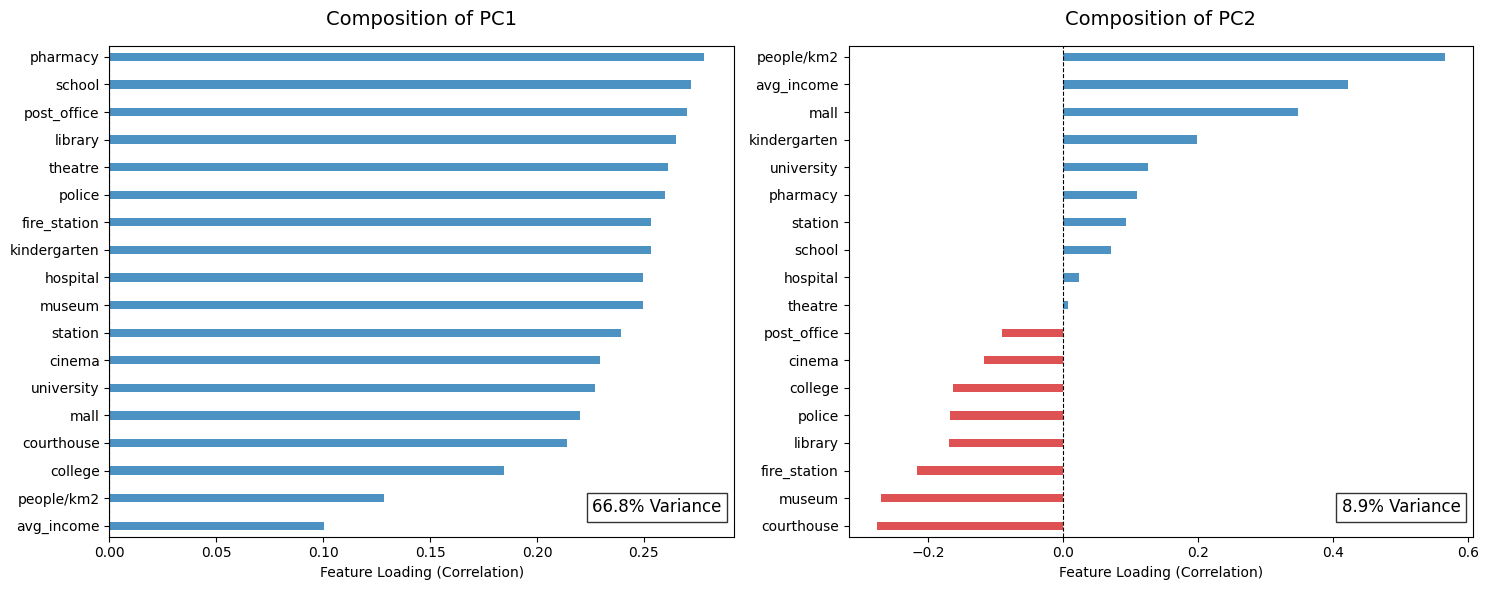

In [6]:
pca_features_fig = pca_engine.plot_component_details()
pca_features_fig.show()

We apply Principal Component Analysis (PCA) independently to each year's dataset to observe how the relationship between Infrastructure (PC1) and Wealth/Density (PC2) evolves over time.

We've observed:

- Structural Stability: The geometry of the projection remains largely consistent across all four years. This indicates that the fundamental correlation between a city's wealth and its available infrastructure is a stable, intrinsic characteristic of the region, not a transient fluctuation.

- Dominant Drivers: The first two components consistently capture a significant majority of the variance (typically >80%), confirming that "Infrastructure" and "Wealth" are indeed the primary forces shaping these urban environments.

- Yearly Consistency: The absence of radical shifts in the scatter plot distribution suggests no sudden structural breaks (e.g., a sudden decoupling of wealth from services) occurred during this period.

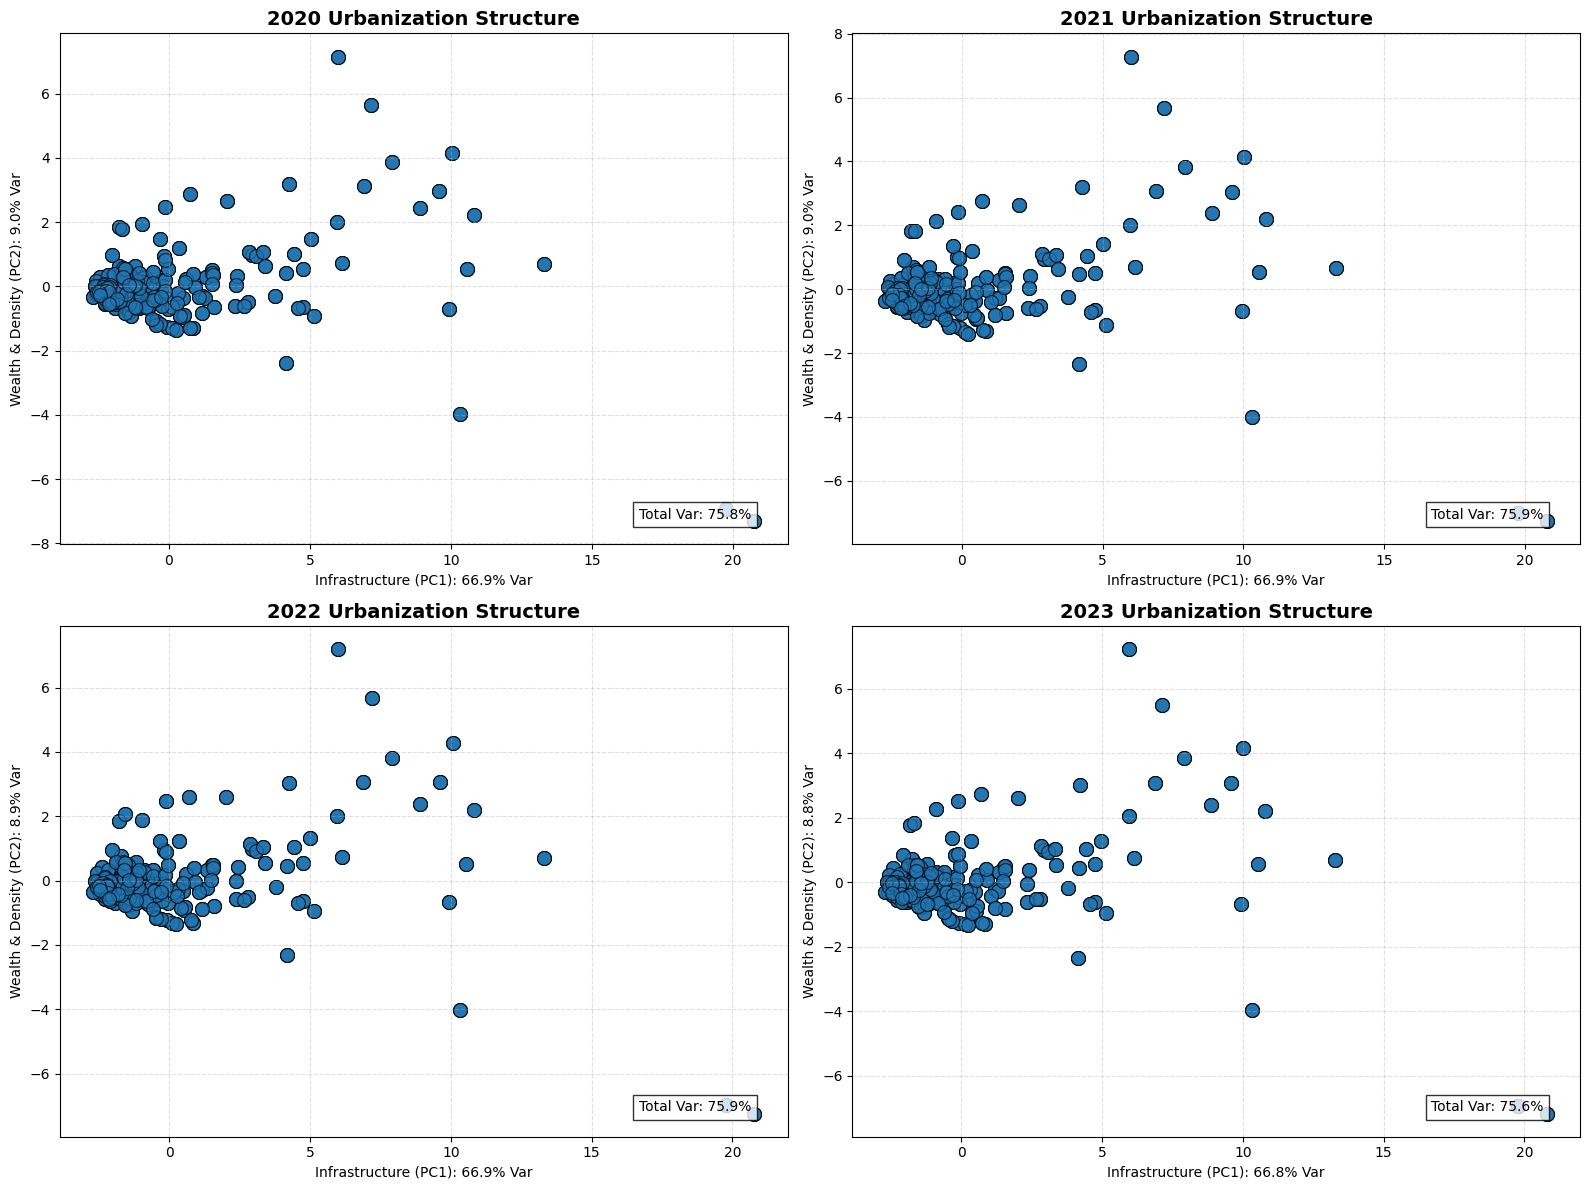

In [7]:
loader = DataLoader(MASTER_DF_FILE)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()  # Flatten to make indexing (0, 1, 2, 3) easier

for i, year in enumerate(YEARS):
    ax = axes[i]
    
    try:
        df_year = loader.get_data_for_year(year, features=config["features"], exclude_values=config["exclude"])
        
        if df_year.empty:
            ax.text(0.5, 0.5, f"No Data for {year}", ha='center', fontsize=14)
            continue

        analyzer = UrbanizationPCA(n_components=2)
        pca_tmp_df = analyzer.run_pca(df_year)
        stats = analyzer.get_variance_stats()
        
        sns.scatterplot(
            x='PC1', 
            y='PC2', 
            data=pca_tmp_df, 
            ax=ax, 
            s=100, 
            alpha=0.7, 
            edgecolor='k',
            legend=False
        )
        
        ax.set_title(f"{year} Urbanization Structure", fontsize=14, weight='bold')
        ax.set_xlabel(f"Infrastructure (PC1): {stats['pc1_var']:.1f}% Var")
        ax.set_ylabel(f"Wealth & Density (PC2): {stats['pc2_var']:.1f}% Var")
        ax.grid(True, linestyle="--", alpha=0.4)
        
        # Add total variance annotation
        ax.text(0.95, 0.05, f"Total Var: {stats['total_var']:.1f}%", 
                transform=ax.transAxes, ha='right', fontsize=10, 
                bbox=dict(facecolor='white', alpha=0.8))

    except Exception as e:
        ax.text(0.5, 0.5, f"Error: {str(e)}", ha='center', color='red')

plt.tight_layout()
plt.show()

The visualization for the data throughout 3 years.

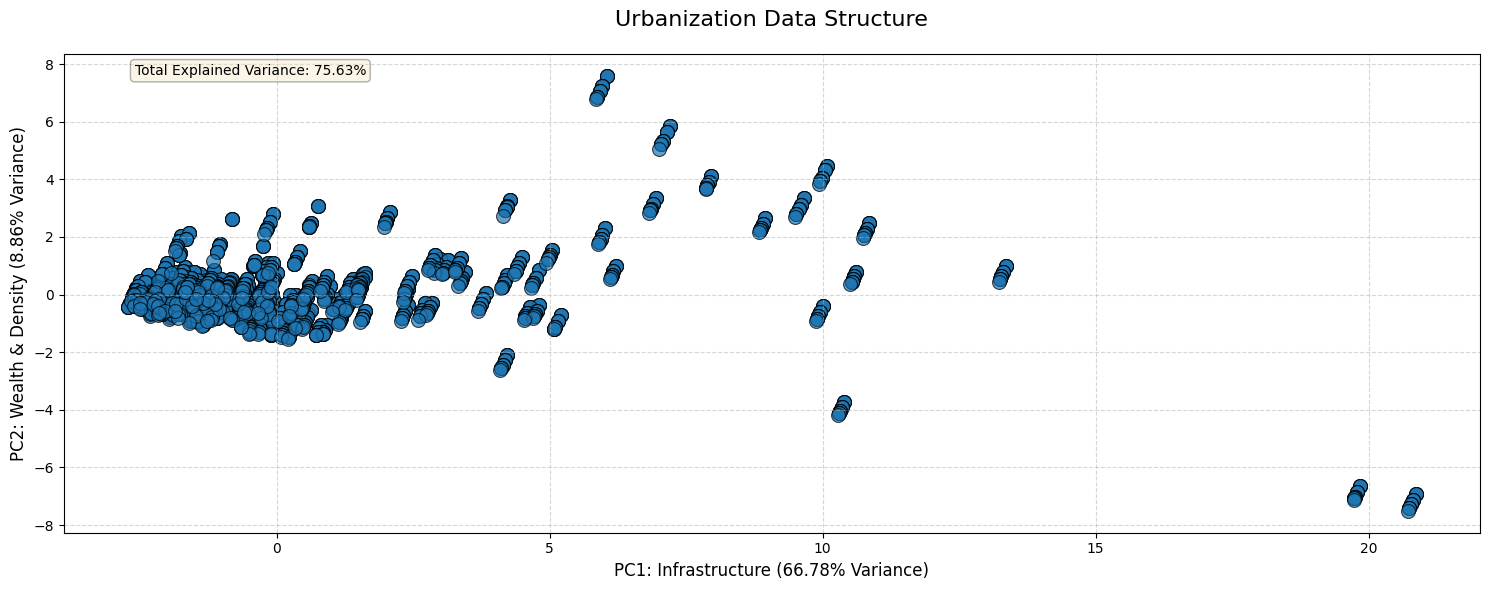

In [8]:
fig = pca_engine.plot_projection()
fig.show()

### Clustering with K-means

Since we've seen that there's no significant difference between years, we'll take the data from 2022 to obtain the clusters. We'll do the clustering with `K-means` in order to get all of the municipalities assigned. 

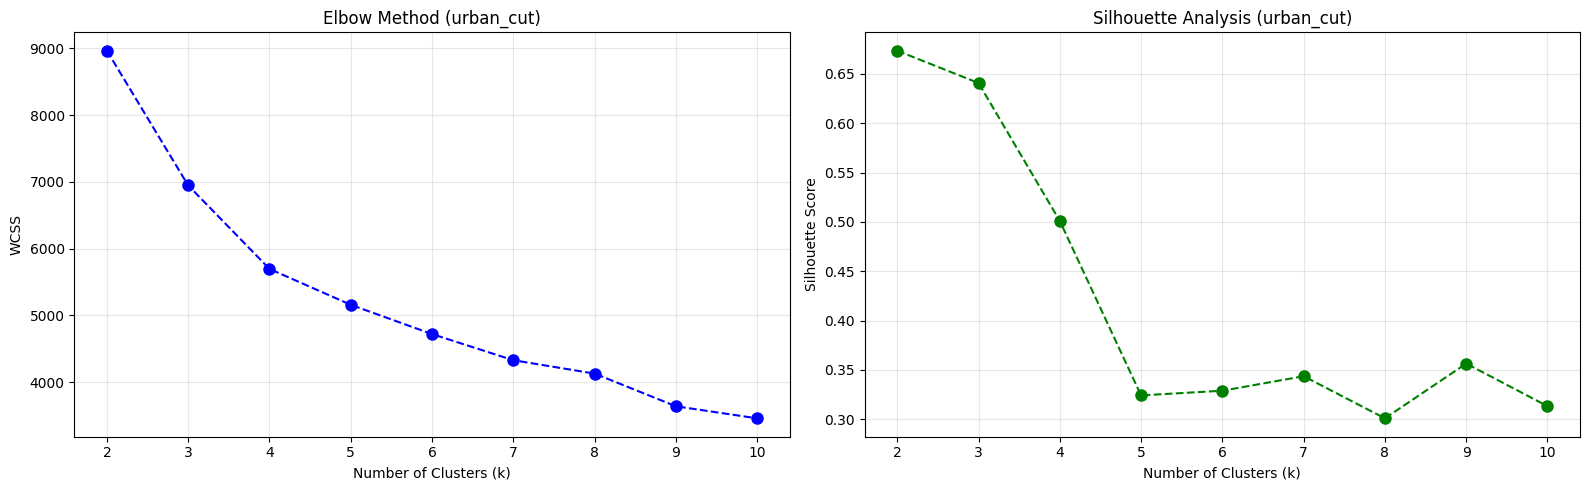

In [9]:
df2022_all = DataLoader(MASTER_DF_FILE).get_data_for_year(year=2022)


engine = ClusteringEngine(experiment_name=EXP_KEY, seed=RANDOM_SEED)
engine.load_and_preprocess(df2022_all)
elbow_fig, cluster_df = engine.run_kmeans_tuning()
elbow_fig.show()

From the plots above we see that the optimal number of clusters should be between 3 and 6 clusters. 3 corresponds to the initial assumption about the existance of the natural 3 clusters like city, town and village.

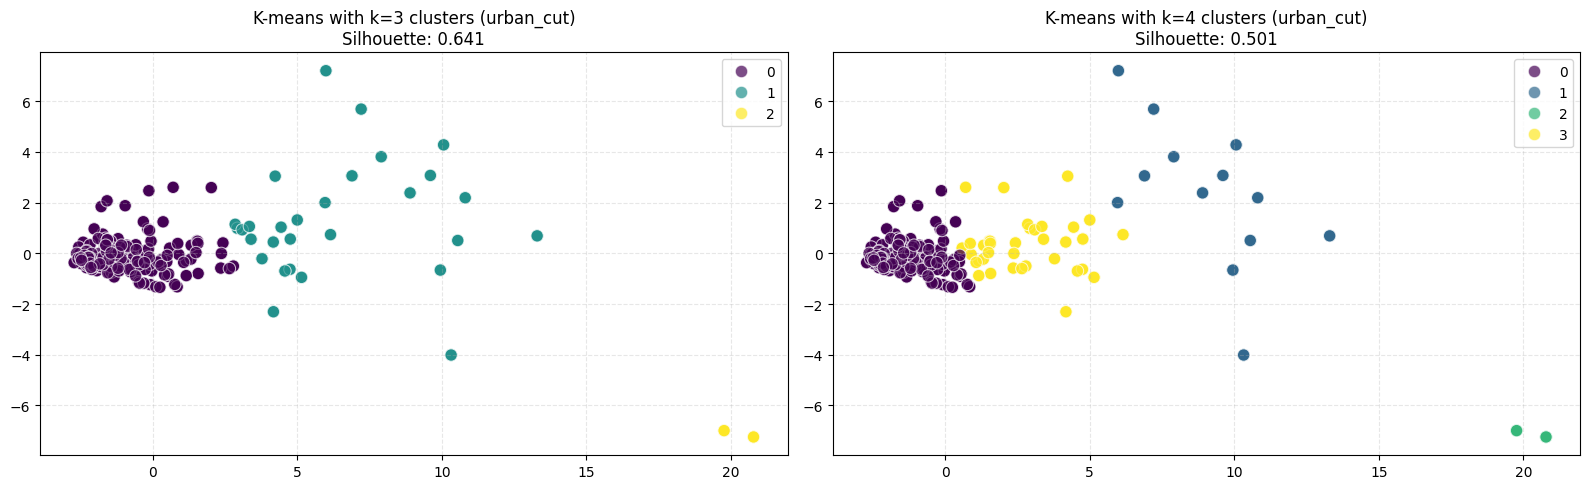

In [10]:
engine.run_batch_training()
df2022_pca = DataLoader(MASTER_DF_FILE).get_data_for_year(year=2022, features=config["features"], exclude_values=config["exclude"])
pca_coords = pca_engine.run_pca(df2022_pca).values
fig = engine.plot_saved_models_from_config(pca_data=pca_coords)
fig.show()

In [11]:
engine.get_cluster_profiles()

,Count,people/km2,avg_income,cinema,college,courthouse,fire_station,hospital,kindergarten,library,mall,museum,pharmacy,police,post_office,school,station,theatre,university
Cluster,,,,,,,,,,,,,,,,,,,
0,720,125.31,1091.30,0.53,0.08,0.79,2.06,0.85,6.51,1.76,0.74,3.97,6.23,3.31,2.92,19.84,2.25,1.36,0.23
1,52,2073.83,1391.13,3.31,2.08,4.00,8.85,8.77,69.69,10.00,20.62,22.23,67.31,18.00,20.31,161.54,22.38,11.31,9.85
2,8,90.20,1196.60,7.50,8.50,13.50,31.50,13.50,76.50,27.50,9.50,72.00,105.00,56.00,47.50,261.50,33.00,23.50,10.00
3,144,446.31,1233.61,1.58,0.97,2.42,5.67,3.67,33.36,4.72,6.94,11.19,28.67,9.53,10.64,84.56,11.97,5.83,2.72


In [12]:
engine.get_cluster_members()

,Members,Count
Cluster,,
0,"[Arcos de Valdevez, Paredes de Coura, Ponte da...",720
1,"[Braga, Guimarães, Maia, Matosinhos, Vila Nova...",52
2,"[Vila Real, Portalegre, Vila Real, Portalegre,...",8
3,"[Viana do Castelo, Barcelos, Vila Nova de Fama...",144


The separation has changed a bit compared to the clustering with Porto and Lisbon, but the difference is not that high. Because of it we'll proceed with the results of the clustering for all of the municipalities. 